In order to successfully complete this assignment you need to:
1. Participate both individually and in groups during class.
2. Submit this notebook to the `exercise` folder in your `cmse802-yourlastname` repository by 10pm __the SAME DAY of the class__. Late assignment will receive <=80% of the grade.

### <p style="text-align: right;"> &#9989; Rupita Tahsin

---
<h1 style="font-size:3em"><b>Make your code run faster</b></h1>


<img src="https://i.ytimg.com/vi/ZBZLx0ZLEJQ/maxresdefault.jpg" alt="Cars racing as a analogy for code running faster" width="50%">

Image From: https://en.wikipedia.org/wiki/Hydra

# Learning objectives

At the end of the exercise, you should be able to:
- Explain common approaches for optimizing programs.
- Optimize your python codes with:
  - Vectorization
  - Numba
  - Parallelism

----
# Outline

1. [Review pre-class assignment](#review)
1. [How do you make Python go faster?](#How_do_you_make_Python_go_faster)
1. [Background](#background)
1. [Example for optimization: wave Equations](#Wave_Equation)
1. [Virtual tour of the HPCC](#Virtual_tour_of_the_HPCC)

----
<a id="review"></a>
# 1. Review of pre-class assignment

In your group, discussion the following.

&#9989; <font color=red>**QUESTION:**</font> Did you get stuck doing pre-class exercise or find some ideas confusing? If so where did you get stuck? What did you find confusing? What solutions did your groupmates suggest?

<font size=+3>&#9998;</font> I had trouble logging into HPCC with my egr account.

&#9989; <font color=red>**QUESTION:**</font> In the pre-class exercise, you were asked to find resources on how to make your codes run faster. What did you and your groupmate found?

<font size=+3>&#9998;</font> 

    Python loops are very slow and using EinSum we can bypass using loops and make the code faster

    Use numpy library because it executes big calculations using C language which is faster


---
<a name="Project_Ideas"></a>
# 2. Project Ideas

We will spend a few moments doing a "**think-pair-share**" exercise.  We need to get some ideas flowing for your programming projects.  Take a few moments to split up into groups, share your ideas.

&#9989; <font color=red>**QUESTION:**</font> What are your groupmates' ideas? Put them down in the space below.

<font size=+3>&#9998;</font> Rupita- looking for the data related to transportation for analysis
Groupmate1- model regarding water system

----
<a id="fair"></a>
# 3. Background

Mini-lecture

----
<a name="Wave_Equation"></a>

# 4. Example for optimization: Wave Equation

<img src="https://i.stack.imgur.com/75vyK.gif" width=25%>

In this section we will explore the speed of a 1D wave equation simulation that is implemented four different ways to illustrate approaches to speed up your code:
- [Basic Python Example](#Basic_Python_Example)
- [Vectorizing code with Numpy](#Vectorizing_code_with_Numpy)
- [Compiling Python code using Numba](#Compiling_Python_code_using_Numba)
- [Parallel Python](#Parallel_Python)

The importance thing to learn here is different way to speed things up, not the details of how wave simulation is done. If you'd like to learn more, the mathematical foundation of wave equation as well as the pseudocodes that connect with the math can be found in the [Appendix](#Wave_equation_overview) section.

<a name="Basic_Python_Example"></a>
## 4.1 Basic Python Example

&#9989; <font color=blue>**DO THIS:**</font> Complete and run the following code blocks and discuss with your groupmate to see what the codes do.

In [7]:
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display, clear_output
import time

def show_animation(delay=0.01):
    fig = plt.gcf()
    time.sleep(delay)       # Sleep for half a second to slow down the animation
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots

In [18]:
# Python only 1D Wave Example
import math 

gamma = 1.0 # wave speed

def wave_sim_basic(show):
    ### Divide simulation into grid in the x direction
    xmin = 0.0                   # Range of x: min value
    xmax = 10.0                  # Range of x: max value
    nx   = 501                   # Number of x values
    dx   = (xmax-xmin)/(nx-1.0)  # Differences between neighboring x values
    x    = [0.0]*nx              # Initialize a list of size = nx with 0s
    for i in range(1,nx):        # Put in x values
        x[i] = xmin + i*dx      

    ### Divide time into discrete units
    nt    = 100000
    tmin  = 0.0
    tmax  = 10.0
    dt    = (tmax-tmin)/(nt-1.0)
    tgrid = [0.0]*nt
    for i in range(1,nt):
        tgrid[i]=tmin+i*dt

    ### Initialize starting position as a simple pulse
    y    = [0.0]*nx
    for i in range(0,nx-1):
        y[i] = math.exp(-(x[i]-5.0)**2)

    ### Initialize velocity and acceleration to zero
    v    = [0.0]*nx
    dvdt = [0.0]*nx

    ### Run the simulation of t timesteps    
    count = 0
    for t in tgrid:
        for i in range(1,nx-1):
          ############################ <== fill the blanks
          dvdt[i] =((y[i+1]-2*y[i]+y[i-1])/((dx)**2)) #Acceleration at xj
        for i in range(0,nx-1):
            y[i] = y[i] + v[i]*dt
            v[i] = v[i] + dvdt[i]*dt

        if not count%2000 and show:
            plt.plot(x, y);
            plt.ylim((-1.05, 1.05))
            plt.title(count)
            show_animation();
        count += 1
        

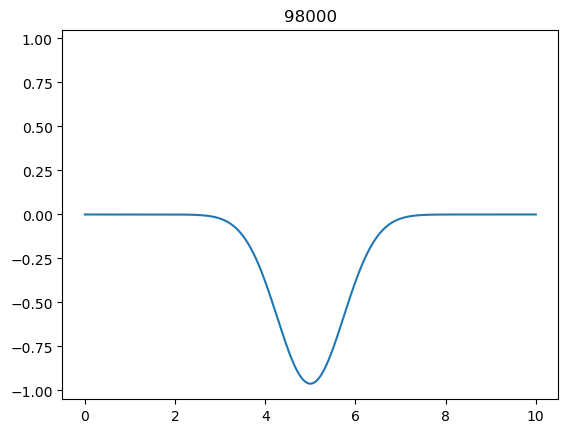

Wall time: 58.8 s


<Figure size 640x480 with 0 Axes>

In [19]:
%%time                       
wave_sim_basic(show=True)

&#9989; <font color=red>**QUESTION:**</font> The magic function `%%time` reports the wall time it takes the cell to run. Report its value in the cell below. Look at the [wikipedia page](https://en.wikipedia.org/wiki/Elapsed_real_time#:~:text=Wall%20time%20is%20thus%20different,system%20resources%20to%20become%20available.) for __walltime__ and __CPU time__. In the CPU time page, __user time__ and __system time__ are also explained. Discuss with your groupmate: what are the difference between them?

<font size=+3>&#9998;</font> The wall time was 55.1 seconds

&#9989; <font color=blue>**DO THIS:**</font> Run the simple python simulation again in the code block below but with the `show` variable set to ```False```. Make sure you also include the magic function to report time.  

In [2]:
%%time                       
wave_sim_basic(show=False)

NameError: name 'wave_sim_basic' is not defined

<a name="Vectorizing_code_with_Numpy"></a>

## 4.2 Vectorizing code with Numpy

Numpy uses C-compiled code to speed up Python. Recall in your pre-class exercise, Numpy is much faster when the matrix get larger quickly. Most slowdown's in code happen when there are big loops.  Numpy uses a lot of very cool tricks (e.g. [vectorization](https://www.manifold.ai/distance-matrix-vectorization-trick)) to make loops go really fast. SO, the trick to making Numpy go fast is to let Numpy run your loops for you.  

&#9989; <font color=blue>**DO THIS:**</font> Below is the Numpy-based implementaion of the 1D Wave example. Run the code block.

In [9]:
#Numpy 1D Wave Example

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

gamma = 1

def wave_sim_numpy(show):
    ### Divide simulation into grid in the x direction
    xmin = 0.0
    xmax = 10.0
    nx   = 501
    x    = np.linspace(xmin, xmax, nx) # Get a numpy array instead of a list 
    dx   = (xmax-xmin)/nx

    ### Divide time into discrete units
    tmin  = 0.0
    tmax  = 10.0
    nt    = 100001
    tgrid = np.linspace(tmin,tmax,nt)  # Get a numpy array instead of a list 
    dt = (tmax-tmin)/nt

    ### Initialize starting position as a simple pulse
    y = np.zeros(nx)                   # Also a numpy array here
    y = np.exp(-(np.array(x)-5.0)**2)  

    ### Initialize velocity and acceleration to zero
    v = np.zeros(nx)                   # Also a numpy array here
    dvdt = np.zeros(nx)                # Also a numpy array here

    count = 0
    ddx = dx*dx                        # Multiple values in the dx vector
                                       # Before it is .../dx/dx

    ### Run the simulation of t timesteps    
    count = 0
    for t in tgrid:
        #laplacian
        dvdt[1:-1] = gamma*(y[2: ]-2*y[1:-1 ]+y[0:-2 ])/ddx  ## vectorized computaing
        y += v*dt
        v += dvdt*dt

        if not count%2000 and show:
            plt.plot(x,y)
            plt.ylim((-1.05, 1.05))
            plt.title(count)
            show_animation()
        count += 1
        

In [10]:
%%time
wave_sim_numpy(show=False)


Wall time: 2.09 s


&#9989; <font color=blue>**DO THIS:**</font> Run the above Numpy-base simulation again in the code block below but with the `show` variable set to ```False```.  Record the time measures it takes to run below.

<a name="Compiling_Python_code_using_Numba"></a>
## 4.3 Compiling Python code using Numba

### What are Numba?

[Numba](https://numba.pydata.org/):
- A module that takes your standard python function and turns it into C-code.
- Then compiles/runs the C version of the funciton and run it. 
- It can speed things up rather dramatically. 
- In this example, we will issue ```@jit``` (Just in time compiling) to convert the code in [the section above](#Vectorizing_code_with_Numpy) to work with numba.  

For more info on what `@` is, see [Appendix](#decorator).

### Using Numba

Here are the steps to use the `@jit` decorator:

- Import the numba jit module: ```from numba import jit```
- Copy all of your code into a function so jit has something to work with.
- Add ```@jit``` with options ___before___ the declaration of the function to enable just-in-time compiling on the function.
- Comment out the plotting command, as ```@jit``` is not able to convert them to c


&#9989; <font color=blue>**DO THIS:**</font> Below is using Numba to compile the Numpy-based 1D Wave example. Complete and run the code block.

In [17]:
from numba import jit 

gamma = 1.0
@jit
def wave_sim_basic(show):
    ### Divide simulation into grid in the x direction
    xmin = 0.0                   # Range of x: min value
    xmax = 10.0                  # Range of x: max value
    nx   = 501                   # Number of x values
    dx   = (xmax-xmin)/(nx-1.0)  # Differences between neighboring x values
    x    = [0.0]*nx              # Initialize a list of size = nx with 0s
    for i in range(1,nx):        # Put in x values
        x[i] = xmin + i*dx      

    ### Divide time into discrete units
    nt    = 100000
    tmin  = 0.0
    tmax  = 10.0
    dt    = (tmax-tmin)/(nt-1.0)
    tgrid = [0.0]*nt
    for i in range(1,nt):
        tgrid[i]=tmin+i*dt

    ### Initialize starting position as a simple pulse
    y    = [0.0]*nx
    for i in range(0,nx-1):
        y[i] = math.exp(-(x[i]-5.0)**2)

    ### Initialize velocity and acceleration to zero
    v    = [0.0]*nx
    dvdt = [0.0]*nx

    ### Run the simulation of t timesteps    
    count = 0
    for t in tgrid:
        for i in range(1,nx-1):
           dvdt[i]= ((y[i+1]-2*y[i]+y[i-1])/((dx)**2)) #Acceleration at xj
        
            
        for i in range(0,nx-1):
            y[i] = y[i] + v[i]*dt
            v[i] = v[i] + dvdt[i]*dt

#         if not count%2000 and show:
#             plt.plot(x, y);
#             plt.ylim((-1.05, 1.05))
#             plt.title(count)
#             show_animation();
        count += 1
    

&#9989; <font color=blue>**DO THIS:**</font> Run the Numba-base simulation and record the time measures it takes to run.

In [13]:
%%time 
wave_sim_numpy(False) # This call will have return a function that transrormed by @jit

Wall time: 2.32 s


<a name="Parallel_Python"></a>

## 4.4 Parallel Python

<img src="https://images-na.ssl-images-amazon.com/images/I/41dqFN7dIrL.jpg" alt="pile of toy snakes as a abstract representation of python running in parallel">
Image from: [https://www.amazon.com/](https://www.amazon.com/)

### What parallel python mean

Finally, another way to achieve speedup is to utilize multiple processors on your computer using, e.g.:
- Python's [multiprocessing module](https://docs.python.org/3/library/multiprocessing.html).
- Numba's [parallel option](https://numba.pydata.org/numba-doc/latest/user/parallel.html). 

It is straightforward to run Numba's parallel option. In the example here, we have the following line:

```python
@jit(parallel=True)
```

### Using Numba's parallel option

Issue is that Numba is still pretty young:
- Sometimes, it does not play well with some very popular packages, including Numpy. And you also see that generating graphics also lead to error earlier.
- Here we will use the basic implementation as example but note couple important changes:
  - We will define a new function named `wave_sim_basic_multiple` which runs the previous wave simulation 100 times by issuing 100 calls of `wave_sim_basic`, each with a different initialization
  - Instead of the python `range` function, use Numba's `prange`, so that the 100 simulations can run in parallel !


In [20]:
from numba import jit, prange
import time
import math
import numpy as np

gamma = 1

@jit(parallel=True)
def wave_sim_basic_multiple():
    num_wave_equ = 100
    for i in prange(num_wave_equ):
        wave_sim_basic(0.1*i)

@jit      
def wave_sim_basic(t0):
    ### Divide simulation into grid in the x direction
    xmin = 0.0                   # Range of x: min value
    xmax = 10.0                  # Range of x: max value
    nx   = 501                   # Number of x values
    dx   = (xmax-xmin)/(nx-1.0)  # Differences between neighboring x values
    x    = [0.0]*nx              # Initialize a list of size = nx with 0s
    for i in range(1,nx):        # Put in x values
        x[i] = xmin + i*dx      

    ### Divide time into discrete units
    nt    = 100000
    tmin  = 0.0
    tmax  = 10.0
    dt    = (tmax-tmin)/(nt-1.0)
    tgrid = [0.0]*nt
    for i in prange(1,nt):
        tgrid[i]=tmin+i*dt

    ### Initialize starting position as a simple pulse
    y    = [0.0]*nx
    for i in range(0,nx-1):
        y[i] = np.exp(-(x[i]-t0)**2)

    ### Initialize velocity and acceleration to zero
    v    = [0.0]*nx
    dvdt = [0.0]*nx

    ### Run the simulation of t timesteps    
    count = 0
    for t in tgrid:
        for i in range(1,nx-1):
            dvdt[i]= gamma*(y[i+1]-2.0*y[i]+y[i-1])/dx/dx ## <== fill the blanks

        for i in prange(0,nx-1):
            y[i] = y[i] + v[i]*dt
            v[i] = v[i] + dvdt[i]*dt
        count += 1

In [26]:
%%time
wave_sim_basic_multiple()


import multiprocessing
multiprocessing.cpu_count()


Wall time: 6.22 s


16

&#9989; <font color=red>**QUESTION:**</font> How does the walltime compared to running the `wave_sim_basic_multiple` function without `@jit(parallel=True`?  What's going on here?

<font size=+3>&#9998;</font> With @jit(parallel=True) the wall time for computation is 6.22 s and without that the execution 
time is 51.8 seconds. With jit enabled to true the numba is computing in parallel and hence the compytation is much faster

# 5. Summarize your results

&#9989; <font color=blue>**DO THIS:**</font> Summarize the walltime in a plot for the following runs (without showing animation):

- Basic wave simulation for various grid sizes `nx` =10, 100, 1000 (obtain one walltime for each grid size)
- Vectorized code with Numpy for various grid sizes `nx`= 10, 100, 1000  
- Numba @jit implementation for various grid sizes `nx` =10, 100, 1000  


In another figure, summarize the walltime in a plot for the following runs (without showing animation):
- Numba-based parallel option of the wave_sim_baisc_multiple function. (obtain walltime for at least 3 different gridsizes)
- Numba-based sequential option of the wave_sim_baisc_multiple function. (obtain walltime for at least 3 different gridsizes)

In [32]:
#In this section I am just redefining the previous wave function with new names, taking out the plotting animation parts
#The functions now take the grid size nx as an input arguments and return the execution time(wall time) 
#from the difference of start time and end time of code execution

import time
def basic_wave(nx):
    st1=time.time()
    ### Divide simulation into grid in the x direction
    xmin = 0.0                   # Range of x: min value
    xmax = 10.0                  # Range of x: max value
    #nx   = 501                   # Number of x values
    dx   = (xmax-xmin)/(nx-1.0)  # Differences between neighboring x values
    x    = [0.0]*nx              # Initialize a list of size = nx with 0s
    for i in range(1,nx):        # Put in x values
        x[i] = xmin + i*dx      

    ### Divide time into discrete units
    nt    = 100000
    tmin  = 0.0
    tmax  = 10.0
    dt    = (tmax-tmin)/(nt-1.0)
    tgrid = [0.0]*nt
    for i in range(1,nt):
        tgrid[i]=tmin+i*dt

    ### Initialize starting position as a simple pulse
    y    = [0.0]*nx
    for i in range(0,nx-1):
        y[i] = math.exp(-(x[i]-5.0)**2)

    ### Initialize velocity and acceleration to zero
    v    = [0.0]*nx
    dvdt = [0.0]*nx

    ### Run the simulation of t timesteps    
    count = 0
    for t in tgrid:
        for i in range(1,nx-1):
          ############################ <== fill the blanks
            dvdt[i]= ((y[i+1]-2*y[i]+y[i-1])/((dx)**2)) #Acceleration at xj
        for i in range(0,nx-1):
            y[i] = y[i] + v[i]*dt
            v[i] = v[i] + dvdt[i]*dt
        count += 1
        et1=time.time()
    speed1=et1-st1
    return speed1

def np_wave(nx):
    st2=time.time()
    ### Divide simulation into grid in the x direction
    xmin = 0.0
    xmax = 10.0
    #nx   = 501
    x    = np.linspace(xmin, xmax, nx) # Get a numpy array instead of a list 
    dx   = (xmax-xmin)/nx

    ### Divide time into discrete units
    tmin  = 0.0
    tmax  = 10.0
    nt    = 100001
    tgrid = np.linspace(tmin,tmax,nt)  # Get a numpy array instead of a list 
    dt = (tmax-tmin)/nt

    ### Initialize starting position as a simple pulse
    y = np.zeros(nx)                   # Also a numpy array here
    y = np.exp(-(np.array(x)-5.0)**2)  

    ### Initialize velocity and acceleration to zero
    v = np.zeros(nx)                   # Also a numpy array here
    dvdt = np.zeros(nx)                # Also a numpy array here

    count = 0
    ddx = dx*dx                        # Multiple values in the dx vector
                                       # Before it is .../dx/dx

    ### Run the simulation of t timesteps    
    count = 0
    for t in tgrid:
        #laplacian
        dvdt[1:-1] = gamma*(y[2: ]-2*y[1:-1 ]+y[0:-2 ])/ddx  ## vectorized computaing
        y += v*dt
        v += dvdt*dt
        count += 1
        et2=time.time()
    speed2=et2-st2
    return speed2

def numba_wave(nx):
    st3=time.time()
    jit(parallel=True)
    def wave_sim_basic_multiple():
        num_wave_equ = 100
        for i in prange(num_wave_equ):
            wave_sim_basic(0.1*i)

    @jit      
    def wave_sim_basic(t0):
        ### Divide simulation into grid in the x direction
        xmin = 0.0                   # Range of x: min value
        xmax = 10.0                  # Range of x: max value
        #nx   = 501                   # Number of x values
        dx   = (xmax-xmin)/(nx-1.0)  # Differences between neighboring x values
        x    = [0.0]*nx              # Initialize a list of size = nx with 0s
        for i in range(1,nx):        # Put in x values
            x[i] = xmin + i*dx      

        ### Divide time into discrete units
        nt    = 100000
        tmin  = 0.0
        tmax  = 10.0
        dt    = (tmax-tmin)/(nt-1.0)
        tgrid = [0.0]*nt
        for i in prange(1,nt):
            tgrid[i]=tmin+i*dt

        ### Initialize starting position as a simple pulse
        y    = [0.0]*nx
        for i in range(0,nx-1):
            y[i] = np.exp(-(x[i]-t0)**2)

        ### Initialize velocity and acceleration to zero
        v    = [0.0]*nx
        dvdt = [0.0]*nx

        ### Run the simulation of t timesteps    
        count = 0
        for t in tgrid:
            for i in range(1,nx-1):
                dvdt[i]= gamma*(y[i+1]-2.0*y[i]+y[i-1])/dx/dx ## <== fill the blanks

            for i in prange(0,nx-1):
                y[i] = y[i] + v[i]*dt
                v[i] = v[i] + dvdt[i]*dt
            count += 1
    et3=time.time()
    speed3=et3-st3
    return speed3


def numba_wave2(nx):
    st4=time.time()
    jit(parallel=False)
    def wave_sim_basic_multiple():
        num_wave_equ = 100
        for i in prange(num_wave_equ):
            wave_sim_basic(0.1*i)
  
    def wave_sim_basic(t0):
        ### Divide simulation into grid in the x direction
        xmin = 0.0                   # Range of x: min value
        xmax = 10.0                  # Range of x: max value
        #nx   = 501                   # Number of x values
        dx   = (xmax-xmin)/(nx-1.0)  # Differences between neighboring x values
        x    = [0.0]*nx              # Initialize a list of size = nx with 0s
        for i in range(1,nx):        # Put in x values
            x[i] = xmin + i*dx      

        ### Divide time into discrete units
        nt    = 100000
        tmin  = 0.0
        tmax  = 10.0
        dt    = (tmax-tmin)/(nt-1.0)
        tgrid = [0.0]*nt
        for i in prange(1,nt):
            tgrid[i]=tmin+i*dt

        ### Initialize starting position as a simple pulse
        y    = [0.0]*nx
        for i in range(0,nx-1):
            y[i] = np.exp(-(x[i]-t0)**2)

        ### Initialize velocity and acceleration to zero
        v    = [0.0]*nx
        dvdt = [0.0]*nx

        ### Run the simulation of t timesteps    
        count = 0
        for t in tgrid:
            for i in range(1,nx-1):
                dvdt[i]= gamma*(y[i+1]-2.0*y[i]+y[i-1])/dx/dx ## <== fill the blanks

            for i in prange(0,nx-1):
                y[i] = y[i] + v[i]*dt
                v[i] = v[i] + dvdt[i]*dt
            count += 1
    et4=time.time()
    speed4=et4-st4
    return speed4  



1.7023115158081055

In [33]:
basic_wave(10)

0.8859548568725586

In [34]:
np_wave(10)

1.7197110652923584

In [35]:
numba_wave(10)

0.0

In [36]:
# Put your code here
#This is the summary of the execution time comparsions as a function of grid size for the three different methods

grid_resolution=[10,100,1000]
speed_basic=[]
speed_np=[]
speed_numba=[]

# Created new functions in the previous cell basic_wave,np_wave and numba_wave by copying the initial code 
#only making it dependent on the grid size nx given as input to the function
for i in range (0,3):
        speed_basic.append(basic_wave(10**(i+1)))
        speed_np.append(np_wave(10**(i+1)))
        speed_numba.append(numba_wave(10**(i+1)))


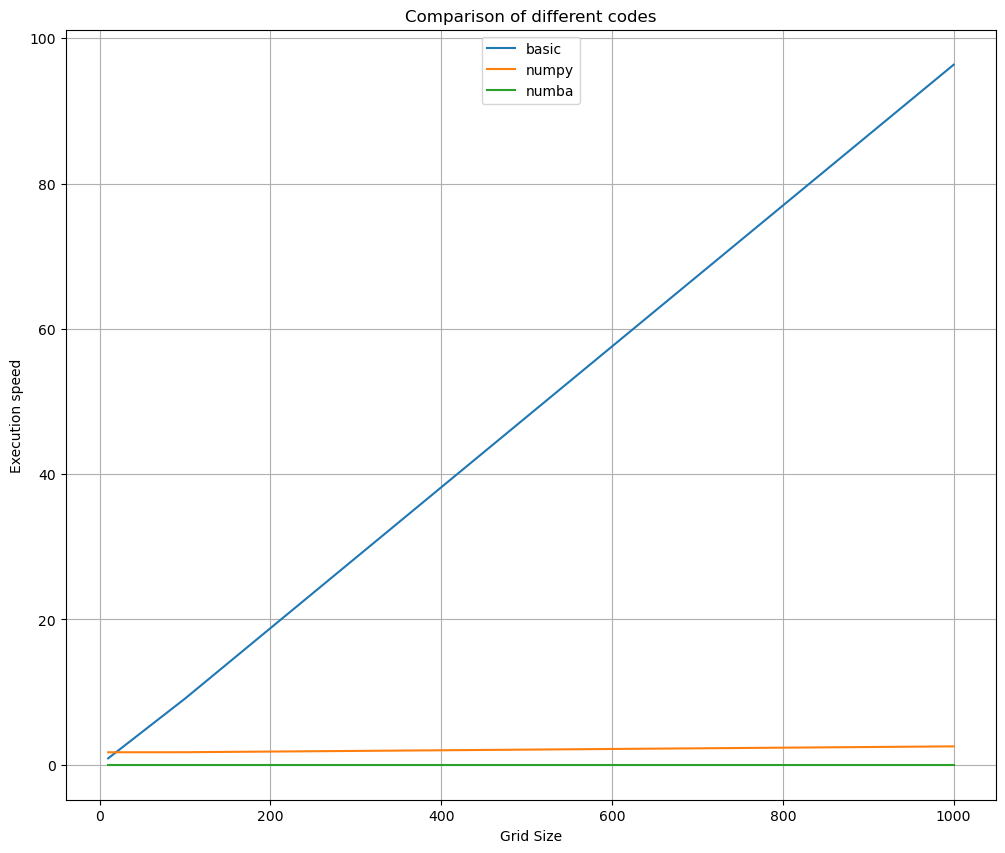

In [39]:
# Plotting the results
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure
figure(figsize=(12, 10))
plot.plot(grid_resolution,speed_basic,label="basic")
plot.plot(grid_resolution,speed_np,label='numpy')
plot.plot(grid_resolution,speed_numba,label='numba')
plot.xlabel("Grid Size")
plot.ylabel("Execution speed")
plot.title("Comparison of different codes")
plot.legend(loc='upper center')
plot.grid()
plot.show()


In [40]:
#This is the speed comparsions as a function of grid size for the numba approach with and without parallel computing (sequential)

grid_resolution=[10,100,1000]
speed_numba_parallel=[]
speed_numba_sequential=[]

# Created new functions in the previous cell basic_wave,np_wave and numba_wave by copying the initial code 
#only making it dependent on the grid size nx given as input to the function
for i in range (0,3):
        speed_numba_parallel.append(numba_wave(10**(i+1)))
        speed_numba_sequential.append(numba_wave2(10**(i+1)))

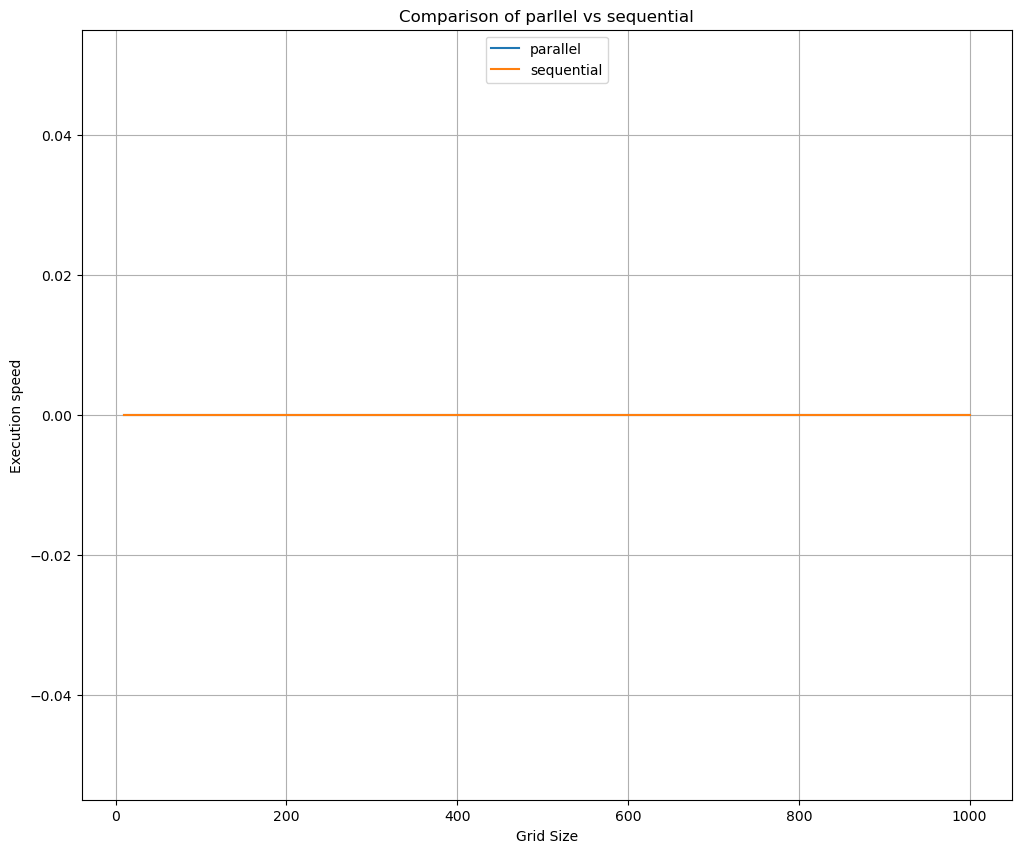

In [41]:
figure(figsize=(12, 10))
plot.plot(grid_resolution,speed_numba_parallel,label="parallel")
plot.plot(grid_resolution,speed_numba_sequential,label='sequential')
plot.xlabel("Grid Size")
plot.ylabel("Execution speed")
plot.title("Comparison of parllel vs sequential")
plot.legend(loc='upper center')
plot.grid()
plot.show()


---------
# Congratulations, you're done with your in-class assignment!

__Please make sure you upload your file by 10pm the same day of the class!__ Late exercise will receive <=80% of the grade.

# Appendix

<a name="Wave_equation_overview"></a>
## Wave equation overview
This subsection describes the math behind this particular 1D wave simulation.  Knowing this math is not important to the lesson on speeding up code but is included for completness.

The wave equation is an second-order linear partial differential equation for the description of waves as they occur in classical physics (for example: water waves, sound waves and seismic waves, light waves).  The basic algorithm splits the wave into a grid of points and calculates the point's position, velocity and acceleration.  The key insight to making the wave equations work is that an individual point will lead/follow the behavior of that points' neighbors.  


In the 1D case we will model a line of points in the x-direction such that they can only move in the y direction. The position for each point  $y$ can be calculated by the particle's previous position and the particle's velocity multiplied by the change in time:

$$y_{i+1} = y_i + \dot{y}_idt$$

Notation:
$$\frac{dy}{dt} = \dot{y} = v = \text{velocity of particle in y direction}$$

We calculation the velocity using the acceleration:

$$\dot{y}_{i+1} = \dot{y}_i + \ddot{y}_idt$$

Notation:
$$\frac{d^2y}{dt^2} = \frac{dv}{dt} = \ddot{y} = a = \text{acceleration of particle in y direction}$$


Given the above equations,  if we know the starting values $y_0$, $\dot{y}_0$, $\ddot{y}_0$ then the only unknown is the equation for how the acceleration changes.  

**If you're interested in knowing the derivation of wave equation, see the [link](http://hyperphysics.phy-astr.gsu.edu/hbase/Waves/waveq.html#c3).**

**Wave Equation:** We will estimate acceleration in time by using acceleration in space. Intuitively we can think about this as any point can estimate where it will be in the future by looking at it's neighbors. Mathematically we show this equation as follows:


$$\frac{d^2y}{dt^2} = \gamma\frac{d^2y}{dx^2}$$

**Numerical discretization.** When we solve differentiation equations numerically, we usually discretization the infinite continuum into finite pieces. For example, instead of 

$$\frac{\partial y}{\partial x},$$ we use $$ \frac{y_{i+1}-y_{i}}{\Delta x},$$

with a very small $\Delta x$. Thus, the second derivative can be expressed as


$$\frac{d^2y}{dx^2} \approx \frac{y[i+1]-2y[i]+y[i-1]}{\Delta x^2}$$

To get the above equation we estimate the velocity to the Left and Right (Before and After) the point of interest using Finite Difference:

$$\frac{\partial y[i]}{\partial x}\bigg|_L \approx \frac{y[i]-y[i-1]}{dx}$$

$$\frac{\partial y[i]}{\partial x}\bigg|_R \approx \frac{y[i+1]-y[i]}{dx}$$

Second, using the Left and Right Velocity,  we use finite difference again to estimate the acceleration:

$$\frac{d^2y}{dx^2} \approx \frac{y[i+1]-2y[i]+y[i-1]}{\Delta x^2} = \frac{a}{\gamma}$$

Given the above we can calculate a point's position at time step $t+1$ by using it's position/velocity at timestep $t$ and it's neighbors position at time step $t-1$.


Pseudocode and settings for 1D Wave Equation

> ### Divide simulation into grid in the x direction
> 
> $x_{min} = 0; x_{max}=10; nx=500$
>
> $dx = \frac{x_{max}-x_{min}}{nx}$
>
> $x = \text{linspace}(x_{min}, x_{max}, nx)$  #Returns a row vector of nx evenly spaced points between x_min and x_max.
>
> ### Divide time into discrete units
>
> $t_{min} = 0; t_{max}=10; nt=1000000$
>
> $dt = \frac{t_{max}-t_{min}}{nt}$
>
> $times = \text{linespace}(t_{min},t_{max}, nt)$ #Returns a row vector of nt evenly spaced points between tmin and tmax.
>
> ### Initialize starting position as a simple pulse
>
> $y_i = e^{-(x_i-5)^2}$ for all $i \in [0,nx)$
>
> ### Initialize velocity and acceleration to zero
>
> $\dot{y}_i = 0$ for all $i \in [0,nx)$
>
> $\ddot{y}_i = 0$ for all $i \in [0,nx)$
>
> $\gamma = 1$
>
> ### Run the simulation of t timesteps
> Loop over index $t$ in $times$:
>
>    > $\ddot{y}_0 = 0$ # Keep acceleration to zero on ends
>    >
>    > $\ddot{y}_{nx-1} = 0$ # Keep acceleration to zero on ends
>    >
>    > $\ddot{y}_i \approx \gamma \frac{y_{(i+1)} -2y_i+ y_{(i-1)}}{dx^2}$ for all $i \in (0,nx-1)$ # Estimate acceleration using position
>    > 
>    > $y_i = y_i + \dot{y}_i dt$   for all $i \in [0,nx)$ # Update position
>    >
>    > $\dot{y}_{i} = \dot{y}_i+ \ddot{y}_idt$   for all $i \in [0,nx)$ # Update velocity


<a name="decorator"></a>
## What is `@`?

- `@jit` specifies a [__decorator__](https://realpython.com/primer-on-python-decorators/), i.e., a function (in this case: `jit`) that transform the function specified beyond the `@` line and return it as another function.

```python
@jit
def wave_sim():
    blah blah
```

- This is the same as:

```python
def wave_sim():
    blah blah
new_function = jit(wave_sim)
```



&#169; Copyright 2021,  Michigan State University Board of Trustees